# Create a Model with TensorFlow (WIP)
This notebook contains the steps needed to build a CNN image classifier.
 

In [225]:
from matplotlib import pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import os

In [ ]:
# fyi add ?? to see documentation 
tf.keras??

### Check for images:

In [226]:
# set the path to images
dataset_dir = './image_scrape_code/screenshots'

# append dir and folder name into a list 
image_files = [
    os.path.join(dataset_dir, filename)
    for filename in os.listdir(dataset_dir)
    if filename.endswith(".png")
]
print(len(image_files))

53


### Resize if needed (Don't run yet):

In [ ]:
# resize
size = 224, 224

# create the dir if it doesn't exist
processed_dir = 'processed_images'
os.makedirs(processed_dir, exist_ok=True)

for i in image_files:
    try:
        im = Image.open(i)
        im.thumbnail(size, Image.Resampling.LANCZOS)
        
        # filename without the path
        filename = os.path.basename(i)
        
        # create new path for the processed image
        processed_path = os.path.join(processed_dir, filename)
        
        # save 
        im.save(processed_path, "PNG")
        
        print(f"Processed {i} saved as {processed_path}")
        
    except IOError:
        print(f"Error rescale for {i}")
        

### Add Lables:

In [227]:
# labels based on file names 
labels = [1 if "person" in filename else 0 for filename in image_files]



## Load Data:

In [ ]:
#skip currently not working
data = tf.keras.utils.image_dataset_from_directory??

In [228]:
# load and preprocess the images
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (256, 256))  # resize to desired dimensions
    image = tf.cast(image, tf.float32) / 255.0  # Scale (normalize pixel values between 0 and 1)
    return image, label


In [229]:
# create a TensorFlow dataset from the image files and labels
dataset = tf.data.Dataset.from_tensor_slices((image_files, labels))
print(len(dataset))

# map the preprocessing function to the dataset
dataset = dataset.map(load_and_preprocess_image)
print(len(dataset))

# shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(image_files),reshuffle_each_iteration=False)
dataset = dataset.batch(batch_size=10) #changed to 10 from 32
print(len(dataset))
data_itr = dataset.as_numpy_iterator()
batch = data_itr.next()


print(len(batch)) #should have two
print(batch[0].shape) 
print(f'Min: {batch[0].min()} Max: {batch[0].max()}')


53
53
6
2
(10, 256, 256, 3)
Min: 0.0 Max: 1.0


### Check Lables:

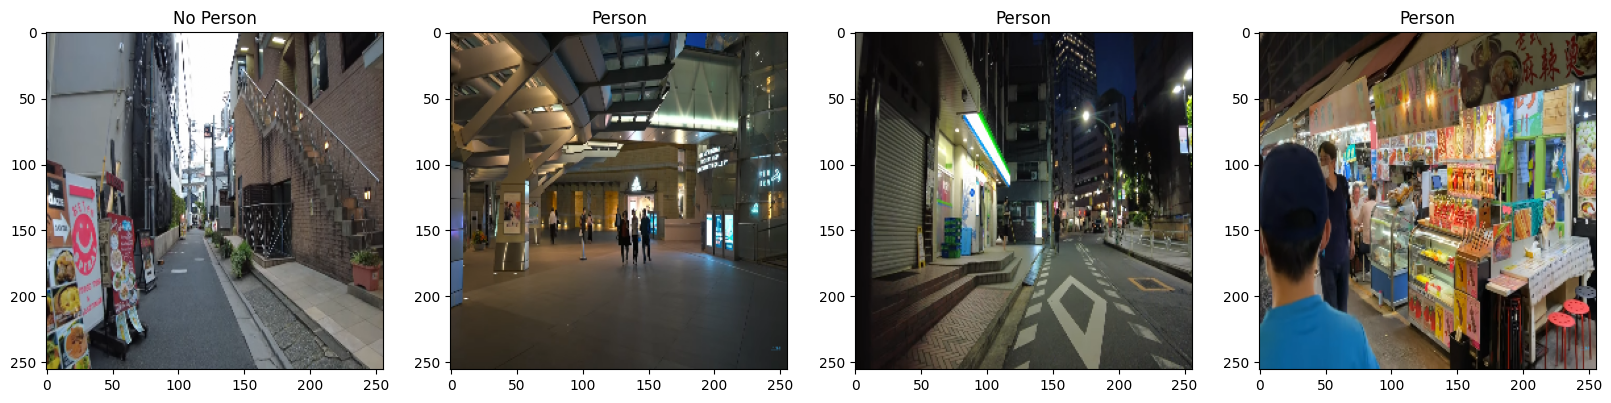

In [231]:

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, (img, label) in enumerate(zip(batch[0][:4], batch[1][:4])):
    ax[idx].imshow(img)
    title = "Person" if label == 1 else "No Person"
    ax[idx].title.set_text(title)
plt.show()


In [ ]:
dataset.as_numpy_iterator().next()

In [153]:
len(dataset)

7

In [233]:
train_size = int(len(dataset)* .7)
val_size = int(len(dataset)*.2) +1
test_size = int(len(dataset)*.1) + 1

In [234]:
print(f'train: {train_size}, Val: {val_size},test:  {test_size}')

train: 4, Val: 2,test:  1


In [235]:
train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size+val_size).take(test_size)

### Build Model:

In [236]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten



In [237]:
model = Sequential()

In [238]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu' ))
model.add(Dense(1,activation='sigmoid' ))

In [239]:
#tf.optimizers??
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

### Note: 
The first param of model.compile is the optimizer (in this case ['adam'](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)).

The optimizer updates the model in response to the output of the loss function.


In [240]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 16)       

In [241]:
logdir='logs'

In [242]:
#for logging how the model training performs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

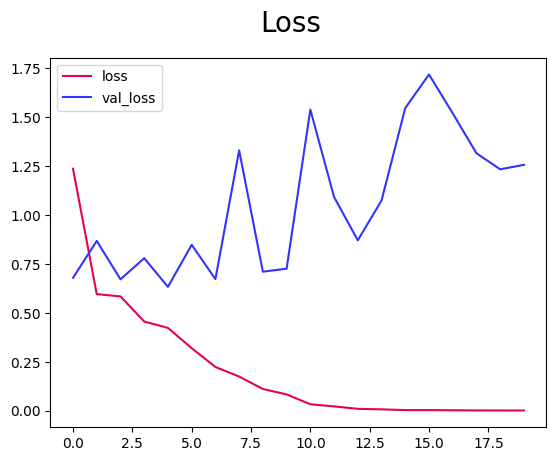

In [244]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='#e6005c', label='loss')
plt.plot(hist.history['val_loss'], color='#3333ff', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


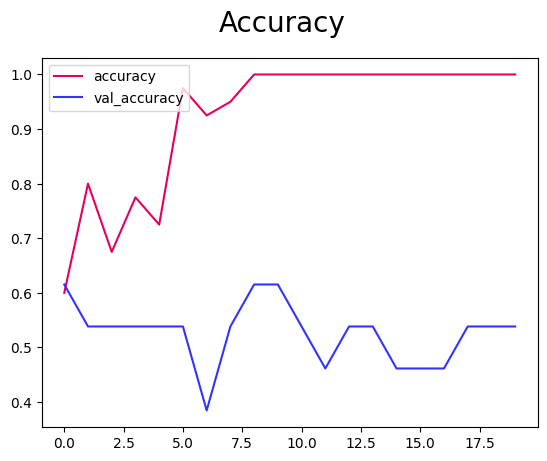

In [245]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='#e6005c', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='#3333ff', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Test Model:

In [246]:
import cv2

In [247]:
# set the path to your dataset
test_dir = './image_scrape_code/test_images'

# append dir and folder name into a list 
test_image_files = [
    os.path.join(test_dir, filename)
    for filename in os.listdir(test_dir)
    if filename.endswith(".png")
]
print(len(test_image_files))

2


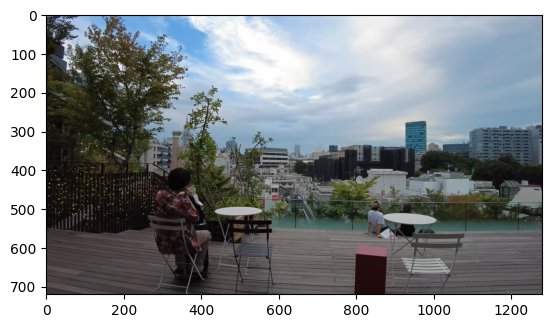

In [248]:
image = test_image_files[1]
img = cv2.imread(image)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

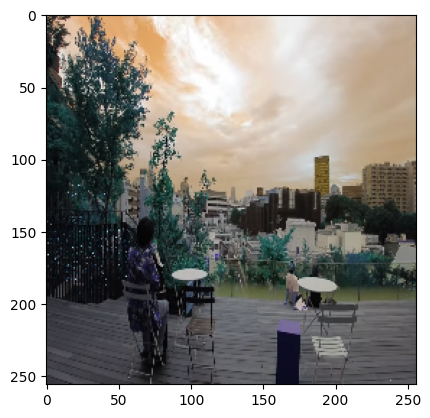

In [249]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [250]:
#the no.expand puts into another array. Our model expects a batch not a sinlge image
prediction = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 85ms/step


In [251]:
prediction

array([[0.5941725]], dtype=float32)

In [252]:
if prediction > 0.5:
    print(f'{image} has a person in it')
else:
     print(f'{image} has no person in it')

./image_scrape_code/test_images/test-person-screenshot-2024-01-28T06-02-38.727Z.png has a person in it


### Evaluate:

In [253]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [254]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [258]:
for batch in test.as_numpy_iterator():
    x,y = batch
    prediction = model.predict(x)
    precision.update_state(y,prediction)
    recall.update_state(y,prediction)
    accuracy.update_state(y,prediction)

In [259]:
print(f'Precision: {precision.result()}, Recall: {recall.result()}, Accuracy: {accuracy.result()} ')

Precision: 0.0, Recall: 0.0, Accuracy: 0.0 


### Save Model:

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models', 'person_in_img_classifier.h5'))
new_model = load_model('person_in_img_classifier.h5')
new_model.predict(np.expand_dims(resize/255,0))